#**Download libreries**


In [148]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import os
import io
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import datetime
import numpy as np
import scipy.stats as stats
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler



#**Download data**

In [3]:
uploaded = files.upload()

Saving hierarchical_sales_data.csv to hierarchical_sales_data.csv


In [75]:
df = pd.read_csv(io.BytesIO(uploaded['hierarchical_sales_data.csv']))
df.head(10)

,DATE,QTY_B1_1,QTY_B1_2,QTY_B1_3,QTY_B1_4,QTY_B1_5,QTY_B1_6,QTY_B1_7,QTY_B1_8,QTY_B1_9,...,PROMO_B4_1,PROMO_B4_2,PROMO_B4_3,PROMO_B4_4,PROMO_B4_5,PROMO_B4_6,PROMO_B4_7,PROMO_B4_8,PROMO_B4_9,PROMO_B4_10
0,2014-01-02,7,3,0,2,3,1,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-03,5,0,0,6,9,1,2,4,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-04,9,7,2,1,5,2,0,6,4,...,0,0,0,0,0,0,0,0,0,0
3,2014-01-05,5,1,2,2,3,0,1,4,5,...,0,0,0,0,0,0,0,0,0,0
4,2014-01-06,1,0,1,0,1,0,0,2,1,...,0,0,0,0,1,0,1,0,0,1
5,2014-01-07,12,2,6,4,1,0,1,4,1,...,1,0,1,1,1,1,1,0,1,1
6,2014-01-08,2,0,5,2,3,0,1,1,5,...,1,1,0,1,0,1,1,1,1,1
7,2014-01-09,2,2,8,2,2,1,0,1,3,...,1,0,0,0,1,0,0,1,1,1
8,2014-01-10,3,2,3,0,1,0,1,3,5,...,1,1,1,0,1,0,0,1,1,1
9,2014-01-11,5,5,7,3,4,2,3,2,7,...,1,0,1,1,1,0,0,1,0,1


In [5]:
df.shape

(1798, 237)

#**Chek Null in our data**

In [6]:
df.isnull().sum()

DATE           0
QTY_B1_1       0
QTY_B1_2       0
QTY_B1_3       0
QTY_B1_4       0
              ..
PROMO_B4_6     0
PROMO_B4_7     0
PROMO_B4_8     0
PROMO_B4_9     0
PROMO_B4_10    0
Length: 237, dtype: int64

#**Build DataFrames called brand_sales that incorporates the 'DATE' column from the original DataFrame and supplements it with separate columns denoting the total quantities for each of the four brands.**




In [84]:
# List of brands
brands = ['B1', 'B2', 'B3', 'B4']

# Create an empty list to store brand sales DataFrames
brand_sales_list = []

# Iterate over each brand
for brand in brands:
    # Select columns that start with 'QTY_' for the current brand
    brand_columns = [col for col in df.columns if col.startswith(f'QTY_{brand}')]
    brand_data = df[brand_columns]

    # Calculate the total quantity for the current brand by summing across columns
    brand_total = brand_data.sum(axis=1)

    # Create a DataFrame for the current brand's sales
    brand_sales = pd.DataFrame({'DATE': df['DATE'], f'QTY_{brand}_TOTAL': brand_total})

    # Append the brand sales DataFrame to the list
    brand_sales_list.append(brand_sales)

# Now you have a list 'brand_sales_list' containing DataFrames for each brand's sales

# Access individual DataFrames using indices
brand_B1_sales = brand_sales_list[0]
brand_B2_sales = brand_sales_list[1]
brand_B3_sales = brand_sales_list[2]
brand_B4_sales = brand_sales_list[3]

#**Let us generate subplots displaying monthly sales data for each brand and each year.**
**Code through the specified years, resamples the data to calculate monthly sums, and then plots the data for each brand. The resulting subplots provide insights into the monthly sales.**

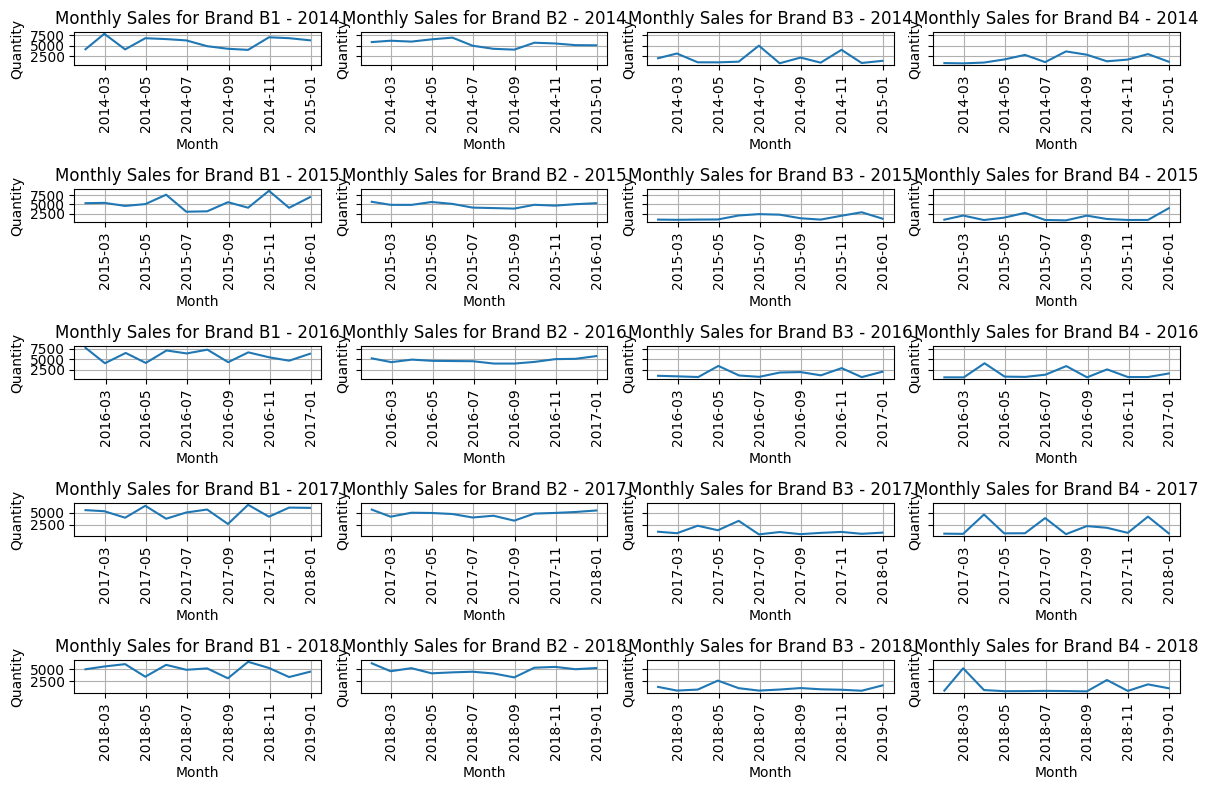

In [85]:
# Assuming 'brand_B1_sales', 'brand_B2_sales', 'brand_B3_sales', 'brand_B4_sales' are DataFrames with sales data
brands = [brand_B1_sales.copy(), brand_B2_sales.copy(), brand_B3_sales.copy(), brand_B4_sales.copy()]

# Labels for each brand
brand_labels = ['Brand B1', 'Brand B2', 'Brand B3', 'Brand B4']

# Years for which to plot monthly sales data
years = [2014, 2015, 2016, 2017, 2018]

# Create an empty dictionary to store monthly sales data for each year
monthly_sales_data_dict = {}

# Get the number of brands and years
num_brands = len(brands)
num_years = len(years)

# Create subplots with shared y-axis for each year and brand
fig, axs = plt.subplots(num_years, num_brands, figsize=(12, 8), sharey='row')

# Iterate over each year
for i, year in enumerate(years):
    # Initialize an empty list for each year to store monthly data
    monthly_sales_data_dict[year] = []

    # Iterate over each brand
    for j, brand_data in enumerate(brands):
        # Convert the 'DATE' column to datetime and set it as the index
        brand_data['Date'] = pd.to_datetime(brand_data['DATE'])
        brand_data.set_index('Date', inplace=True)

        # Resample the data to get monthly sums
        monthly_data = brand_data['QTY_B{}_TOTAL'.format(j + 1)].resample('M').sum()

        # Select data for the current year
        year_data = monthly_data[monthly_data.index.year == year]
        monthly_sales_data_dict[year].append(year_data.values)  # Append the data to the list

        # Get the corresponding subplot axis
        ax = axs[i, j]

        # Plot monthly sales data
        ax.plot(year_data.index, year_data.values)
        ax.set_xlabel('Month')
        ax.set_ylabel('Quantity')
        ax.set_title(f'Monthly Sales for {brand_labels[j]} - {year}')
        ax.tick_params(axis='x', rotation=90)
        ax.grid(True)

# Adjust layout and display the plots
fig.tight_layout()
plt.show()


#**Conduct an ANOVA test**
**To check if sales in a month
differ from year to year. Our null hypothesis (H0) is that the mean sales for
each month do not differ from each other. If the p-value is below a certain
significance level, we may reject the null hypothesis, indicating that there
are significant differences in sales between months across different years.**


In [91]:
# Iterate over each year and its corresponding list of monthly sales values
for year, values in monthly_sales_data_dict.items():
    # Perform one-way ANOVA test on the list of values
    result = stats.f_oneway(*values)

    # Print ANOVA results for the current year
    print(f"ANOVA for {year}:")
    print(result)
    if result.pvalue < 0.05:
        print("Statistically significant differences in sales across months for", year)
        # Additional analysis or actions can be performed when the condition is met
    else:
        print("No statistically significant differences in sales across months for", year)
    print("\n")



ANOVA for 2014:
F_onewayResult(statistic=40.8826906251235, pvalue=8.792063261585463e-13)
Statistically significant differences in sales across months for 2014


ANOVA for 2015:
F_onewayResult(statistic=42.01395264877433, pvalue=5.661464496508869e-13)
Statistically significant differences in sales across months for 2015


ANOVA for 2016:
F_onewayResult(statistic=57.057292453805665, pvalue=3.298886611471733e-15)
Statistically significant differences in sales across months for 2016


ANOVA for 2017:
F_onewayResult(statistic=38.04688913022271, pvalue=2.7590124451639222e-12)
Statistically significant differences in sales across months for 2017


ANOVA for 2018:
F_onewayResult(statistic=51.517869015075384, pvalue=1.9136883030772584e-14)
Statistically significant differences in sales across months for 2018




#**Calculate the lower and upper bounds for outlier detection.**
**The bounds are calculated as the mean of the column minus 3 times the standard deviation (lower bound) and plus 3 times the standard deviation (upper bound).**

In [92]:
# Calculate the standard deviation of the 'QTY_B1_TOTAL' column
std = brand_B1_sales['QTY_B1_TOTAL'].std()

# Calculate the lower and upper bounds for outlier detection using the mean and 3 times the standard deviation
lower_bound = brand_B1_sales['QTY_B1_TOTAL'].mean() - 3 * std
upper_bound = brand_B1_sales['QTY_B1_TOTAL'].mean() + 3 * std

# Identify outliers by filtering data outside the calculated bounds
outliers = brand_B1_sales[(brand_B1_sales['QTY_B1_TOTAL'] < lower_bound) | (brand_B1_sales['QTY_B1_TOTAL'] > upper_bound)]

# Print the identified outliers
print("Outliers in Brand B1 Sales:")
print(outliers)

Outliers in Brand B1 Sales:
            DATE  QTY_B1_TOTAL
43    2014-02-14           575
44    2014-02-15           705
49    2014-02-20           585
51    2014-02-22           704
100   2014-04-12           571
107   2014-04-19           665
145   2014-05-29           646
146   2014-05-30           757
147   2014-05-31           931
154   2014-06-07           568
270   2014-10-02           542
272   2014-10-04           610
312   2014-11-13           599
314   2014-11-15           675
321   2014-11-22           679
349   2014-12-20           613
388   2015-01-30           550
389   2015-01-31           856
492   2015-05-16           876
499   2015-05-23           668
629   2015-10-01           614
630   2015-10-02           669
631   2015-10-03           895
638   2015-10-10           644
739   2016-01-21           615
740   2016-01-22           538
741   2016-01-23           749
748   2016-01-30           569
797   2016-03-19           565
844   2016-05-07           602
851   2016-

#**Normalization of our data.**
**A threshold value is set to determine which data points are considered outliers.
Z-scores are calculated for each data point, indicating how much a value deviates from the average.
Outliers are pinpointed by comparing the calculated z-scores to the set threshold.
A new dataset is generated, mirroring the original, and anomalies are substituted with NaN values.
The smoothed data with outliers replaced is displayed for examination.
A visual representation is provided by plotting the original and smoothed data without outliers.**

            DATE  QTY_B1_TOTAL
0     2014-01-02         101.0
1     2014-01-03         136.0
2     2014-01-04         162.0
3     2014-01-05         106.0
4     2014-01-06          47.0
...          ...           ...
1793  2018-12-27         203.0
1794  2018-12-28         192.0
1795  2018-12-29         158.0
1796  2018-12-30         182.0
1797  2018-12-31         243.0

[1798 rows x 2 columns]


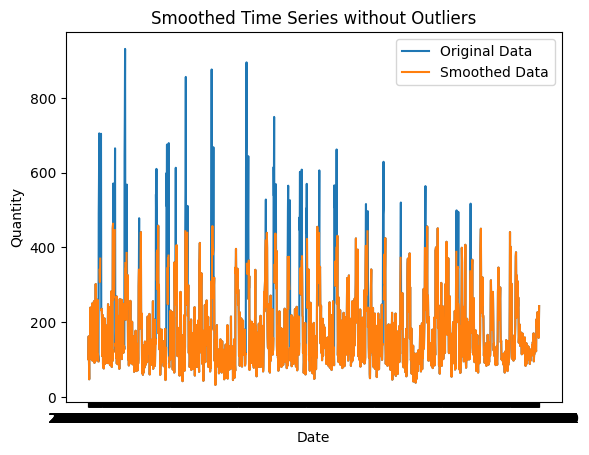

In [19]:

# Define the threshold for identifying outliers
threshold = 2.5

# Calculate the z-scores for each data point
z_scores = np.abs((brand_B1_sales['QTY_B1_TOTAL'] - brand_B1_sales['QTY_B1_TOTAL'].mean()) / brand_B1_sales['QTY_B1_TOTAL'].std())

# Identify the outliers using the threshold
outliers = z_scores > threshold

# Create a copy of the original data and replace the outliers with NaN values
smoothed_data = brand_B1_sales[['DATE', 'QTY_B1_TOTAL']].copy()
smoothed_data.loc[outliers, 'QTY_B1_TOTAL'] = np.nan
smoothed_data.reset_index(drop=True, inplace=True)
print(smoothed_data)
# Plot the original data and the smoothed data without outliers
plt.plot(brand_B1_sales['DATE'], brand_B1_sales['QTY_B1_TOTAL'], label='Original Data')
plt.plot(smoothed_data['DATE'], smoothed_data['QTY_B1_TOTAL'], label='Smoothed Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Smoothed Time Series without Outliers')
plt.legend()
plt.show()


#Try to use the rolling window technique to enhance data interpretation by reducing noise and highlighting trends.**

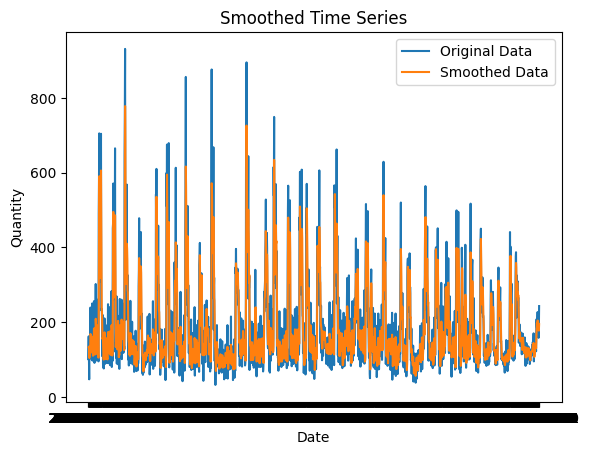

In [93]:
# Define the window size for smoothing
window_size = 3

# Smooth the data using a rolling window and calculate the moving average
smoothed_data_window = brand_B1_sales['QTY_B1_TOTAL'].rolling(window=window_size).mean()

# Plot the original data and the smoothed data using a rolling window
plt.plot(brand_B1_sales['DATE'], brand_B1_sales['QTY_B1_TOTAL'], label='Original Data')
plt.plot(brand_B1_sales['DATE'], smoothed_data_window, label='Smoothed Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Smoothed Time Series')
plt.legend()
plt.show()

In [94]:
smoothed_data.isna().sum()
smoothed_data = smoothed_data.dropna()


#**Conducting a stationarity check using the Augmented Dickey-Fuller test before proceeding with time series analysis and forecasting.**

In [98]:
# Calculate the Augmented Dickey-Fuller test on the smoothed data
result = adfuller(smoothed_data['QTY_B1_TOTAL'])
# Print the p-value from the Augmented Dickey-Fuller test
print('p-value:', result[1])
if result[1] < 0.05:
    print("The data is likely stationary.")
else:
    print("The data is likely non-stationary and may require additional processing.")

p-value: 8.924537538170041e-18
The data is likely stationary.


#**Seasonal decomposition**

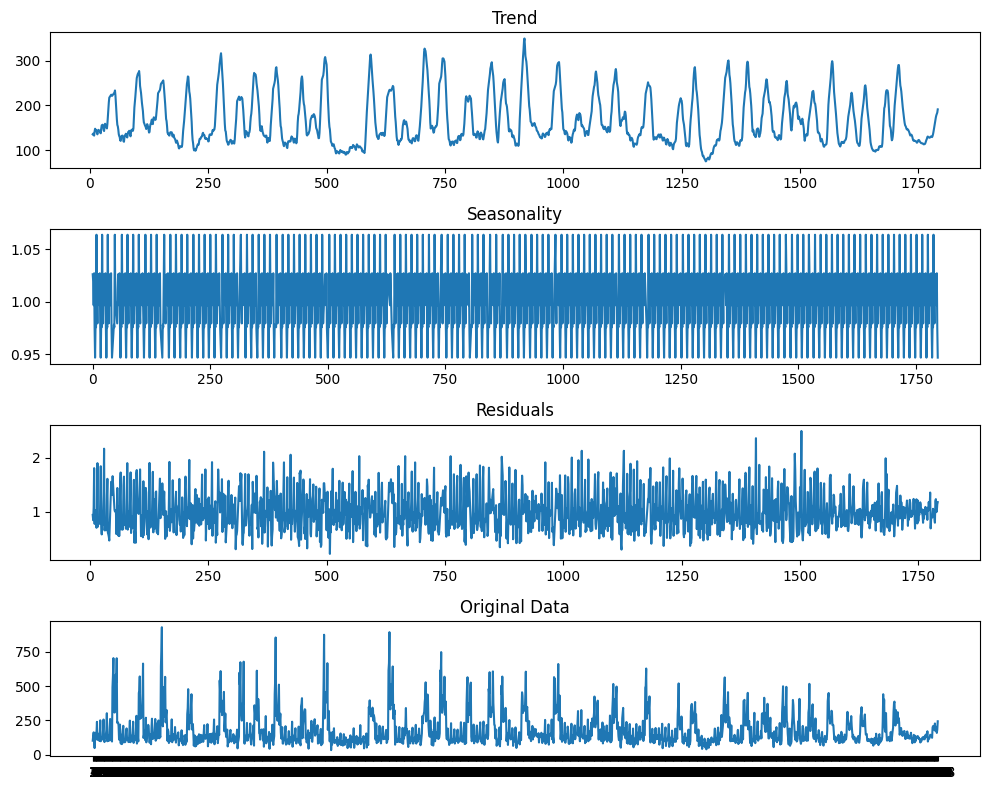

In [28]:

# Perform seasonal decomposition
decomposition = seasonal_decompose(smoothed_data['QTY_B1_TOTAL'], model='multiplicative', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(trend)
plt.title('Trend')
plt.subplot(4, 1, 2)
plt.plot(seasonal)
plt.title('Seasonality')
plt.subplot(4, 1, 3)
plt.plot(residual)
plt.title('Residuals')
plt.subplot(4, 1, 4)
plt.plot(brand_B1_sales['QTY_B1_TOTAL'])
plt.title('Original Data')
plt.tight_layout()
plt.show()

#**Calculate and plot the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF).**
**In the ACF plot, each blue bar represents the correlation at a specific lag. Significant correlations outside the
shaded region may suggest the need for an MA term.
In the PACF plot, each blue bar represents the partial correlation at a specific lag. Significant correlations
outside the shaded region may suggest the need for an AR term.**

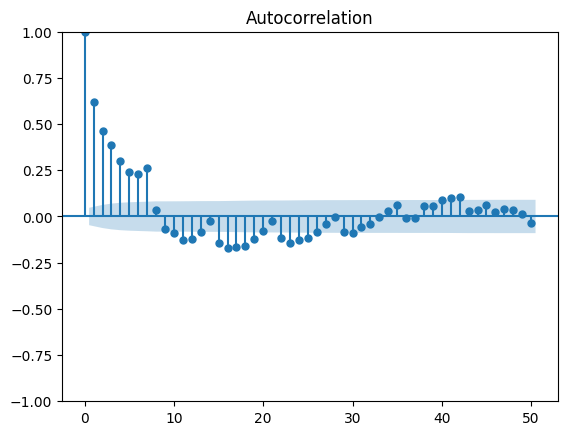

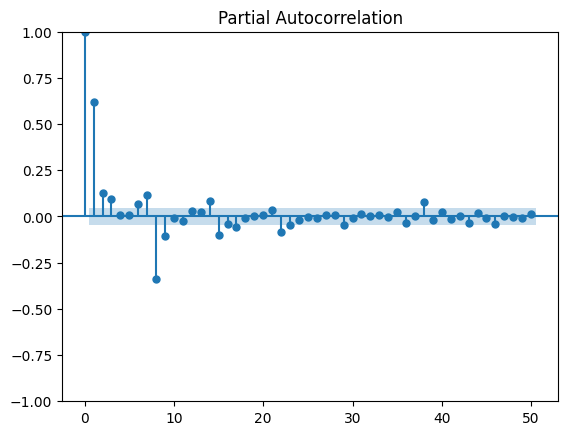

In [29]:
# Calculate and plot the AutoCorrelation Function (ACF)
acf = plot_acf(smoothed_data['QTY_B1_TOTAL'], lags=50)
acf.show()

# Calculate and plot the Partial AutoCorrelation Function (PACF)
pacf = plot_pacf(smoothed_data['QTY_B1_TOTAL'], lags=50)
pacf.show()


#**Exploring with Auto ARIMA for precise parameter selection**

In [32]:
model = auto_arima(smoothed_data['QTY_B1_TOTAL'], seasonal=False)

order = model.order
print(order)

(5, 0, 5)


#**Forecast future values using the ARIMA (AutoRegressive Integrated Moving Average) modeling technique.**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



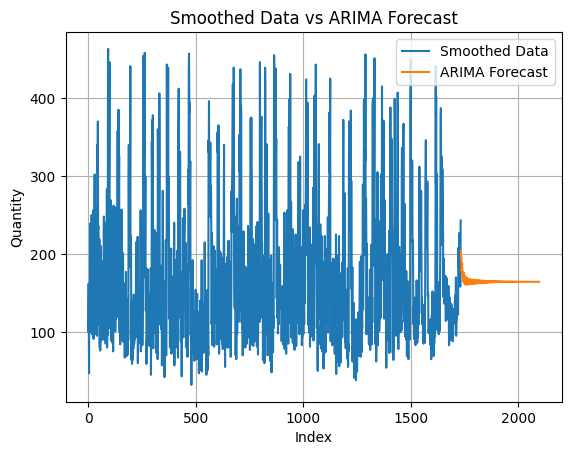

In [104]:
# Reset the index of the smoothed data for consistency
smoothed_data = smoothed_data.reset_index(drop=True)

# Create an ARIMA model with specified order (5, 0, 5)
model = ARIMA(smoothed_data['QTY_B1_TOTAL'], order=(5, 0, 5))
model_fit = model.fit()  # Fit the model to the data

n_periods = 365  # Define the number of forecasted periods

# Generate predicted values using the ARIMA model
predicted_values = model_fit.predict(start=len(smoothed_data), end=len(smoothed_data) + n_periods - 1)

# Plot the original smoothed data and the ARIMA forecast
plt.plot(range(len(smoothed_data)), smoothed_data['QTY_B1_TOTAL'], label='Smoothed Data')
plt.plot(range(len(smoothed_data), len(smoothed_data) + n_periods), predicted_values, label='ARIMA Forecast')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.title('Smoothed Data vs ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

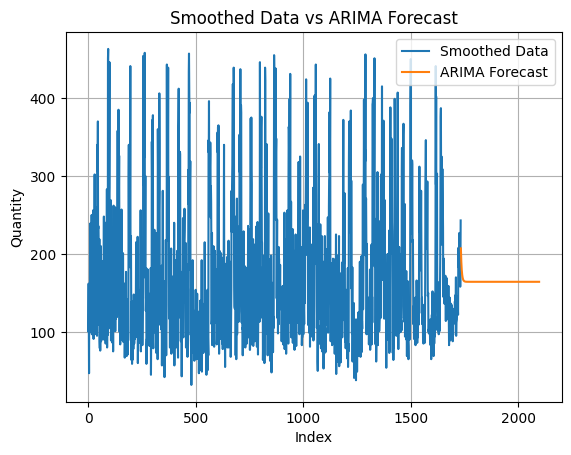

In [99]:
# Reset the index of the smoothed data for consistency
smoothed_data = smoothed_data.reset_index(drop=True)

# Create an ARIMA model with specified order (1, 0, 1)
model = ARIMA(smoothed_data['QTY_B1_TOTAL'], order=(1, 0, 1))
model_fit = model.fit()  # Fit the model to the data

n_periods = 365  # Define the number of forecasted periods

# Generate predicted values using the ARIMA model
predicted_values = model_fit.predict(start=len(smoothed_data), end=len(smoothed_data) + n_periods - 1)

# Plot the original smoothed data and the ARIMA forecast
plt.plot(range(len(smoothed_data)), smoothed_data['QTY_B1_TOTAL'], label='Smoothed Data')
plt.plot(range(len(smoothed_data), len(smoothed_data) + n_periods), predicted_values, label='ARIMA Forecast')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.title('Smoothed Data vs ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

#**Function make_forecast**
**This function, make_forecast, takes in input data, the number of periods to forecast (n_periods), and the number of steps to take in each iteration (steps). It iterates through the specified number of periods, creates an ARIMA model, generates forecasts, and extends the dataset with new values and dates. The resulting forecast_df DataFrame contains the forecasted dates and values.**

In [ ]:
def make_forecast(data, n_periods, steps):
    # Extract the last 1780 data points of QTY_B1_TOTAL
    last_data = data['QTY_B1_TOTAL'][-1780:]

    forecasted_values = []  # Initialize a list to store forecasted values
    new_dates = []  # Initialize a list to store new dates corresponding to forecasted values

    # Iterate through the specified number of periods, taking steps at a time
    for n in range(int(n_periods / steps)):
        # Create an ARIMA model with order (5, 0, 5) and fit it to the last_data
        model = ARIMA(last_data, order=(5, 0, 5))
        model_fit = model.fit()

        # Forecast the next 'steps' values using the fitted model
        forecast = model_fit.forecast(steps)

        # Get the last date from the original data
        last_date_str = data['DATE'].iloc[-1]

        # Convert the last date string to a datetime object
        date_1 = datetime.datetime.strptime(last_date_str, "%Y-%m-%d")

        # Calculate the end date of the forecast based on the number of periods
        end_date = date_1 + datetime.timedelta(days=n_periods - 1)

        # Generate a sequence of new dates using daily frequency
        new_dates = pd.date_range(start=date_1, end=end_date, freq='D')

        # Extend the list of forecasted values with the new forecast values
        forecasted_values.extend(forecast)

        # Extend last_data with the forecasted values and corresponding new dates
        last_data = pd.concat([last_data, pd.Series(forecast, index=new_dates[-len(forecast):])])

    # Create a DataFrame to store forecasted dates and values
    forecast_df = pd.DataFrame({'Date': new_dates, 'Forecast': forecasted_values})
    return forecast_df

# Assuming smoothed_data['QTY_B1_TOTAL'] is a pandas DataFrame with columns 'DATE' and 'QTY_B1_TOTAL'
# Generate a forecast DataFrame using the make_forecast function
forecast_df = make_forecast(smoothed_data, 90, 30)

In [147]:
smoothed_data_forecast = smoothed_data[-100:]

#**Compare the actual data with the forecasted values**

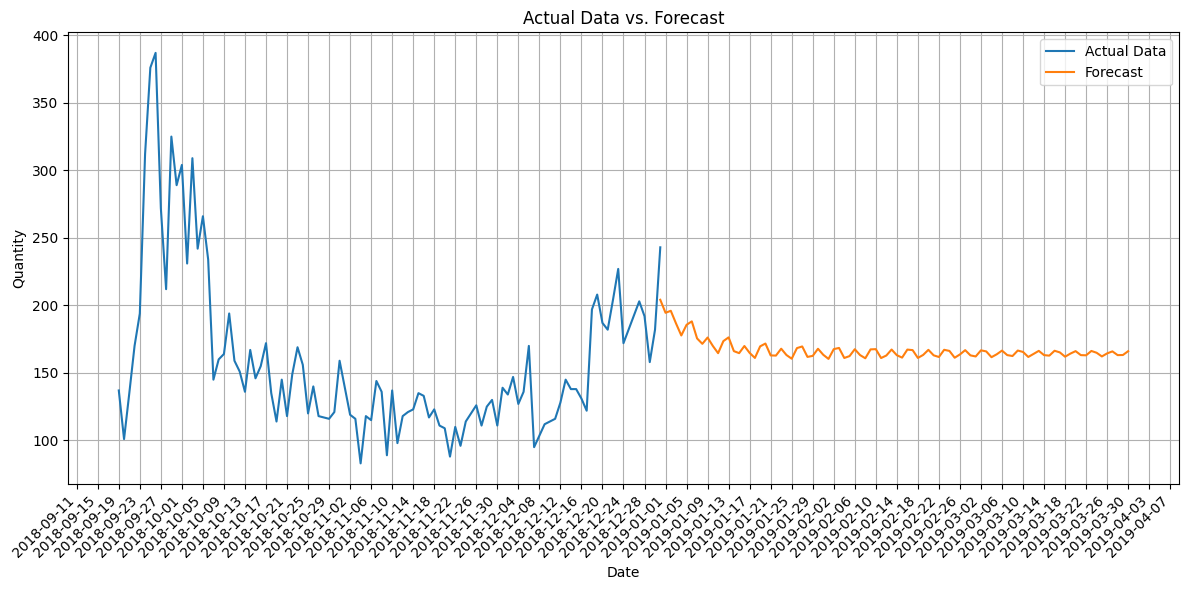

In [116]:

# Convert the 'DATE' column to a pandas datetime type with the appropriate format and timezone
#smoothed_data_forecast['DATE'] = pd.to_datetime(smoothed_data_forecast['DATE'], format='%Y-%m-%d').dt.tz_localize('UTC')

# Assuming forecast_df is a DataFrame containing the forecasted values
#forecast_df['Date'] = pd.to_datetime(forecast_df['Date'], format='%Y-%m-%d').dt.tz_localize('UTC')

plt.figure(figsize=(12, 6))
plt.plot(smoothed_data_forecast['DATE'], smoothed_data_forecast['QTY_B1_TOTAL'], label='Actual Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual Data vs. Forecast')

plt.grid(True)
plt.legend()

# Set the tick frequency to show only every 4th tick (adjust the interval as needed)
tick_interval = 4
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_interval))

plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()



#**Prophet**

In [123]:

df = brand_B1_sales.copy()
df.columns = ['ds', 'y']

#**Fitting the model**

In [ ]:
m = Prophet(weekly_seasonality=True)
m.fit(df)

#**Make cross validation**

In [ ]:
cv_results = cross_validation(m, initial='365 days', period='180 days', horizon='365 days')


#**Calculate average performance metrics**

In [149]:

# Calculate performance metrics
metrics = performance_metrics(cv_results)
average_mae = metrics['mae'].mean()
average_rmse = metrics['rmse'].mean()
average_mse = metrics['mse'].mean()

print("Average MAE:", average_mae)
print("Average RMSE:", average_rmse)
print("Average MSE:", average_mse)

Average MAE: 82.8002475466858
Average RMSE: 110.25552563865158
Average MSE: 12344.420716347127


#**Make forecast**

In [132]:
future = m.make_future_dataframe(periods=150)
future.head()
forecast = m.predict(future)

#**Plot forecast**

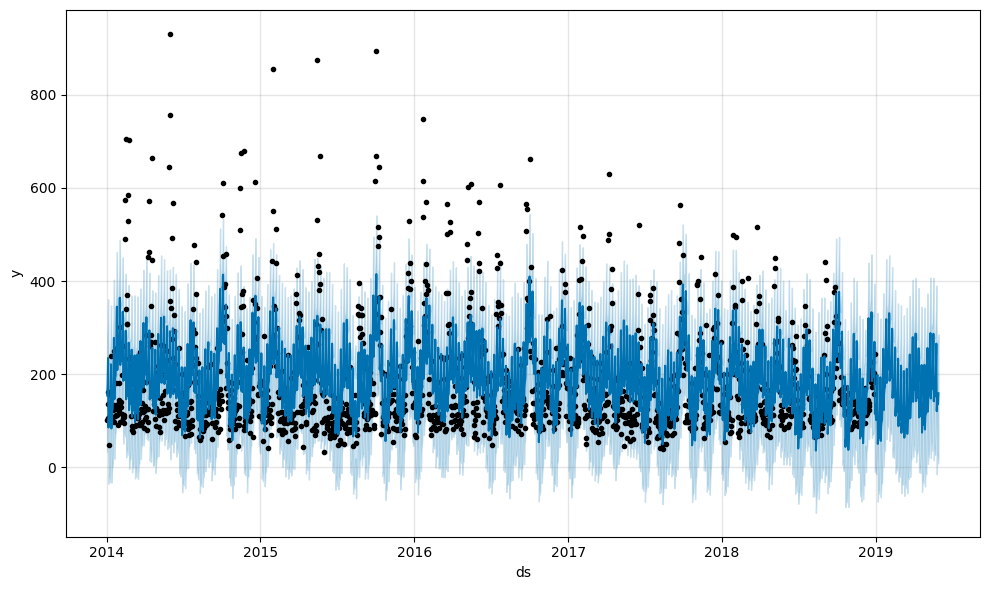

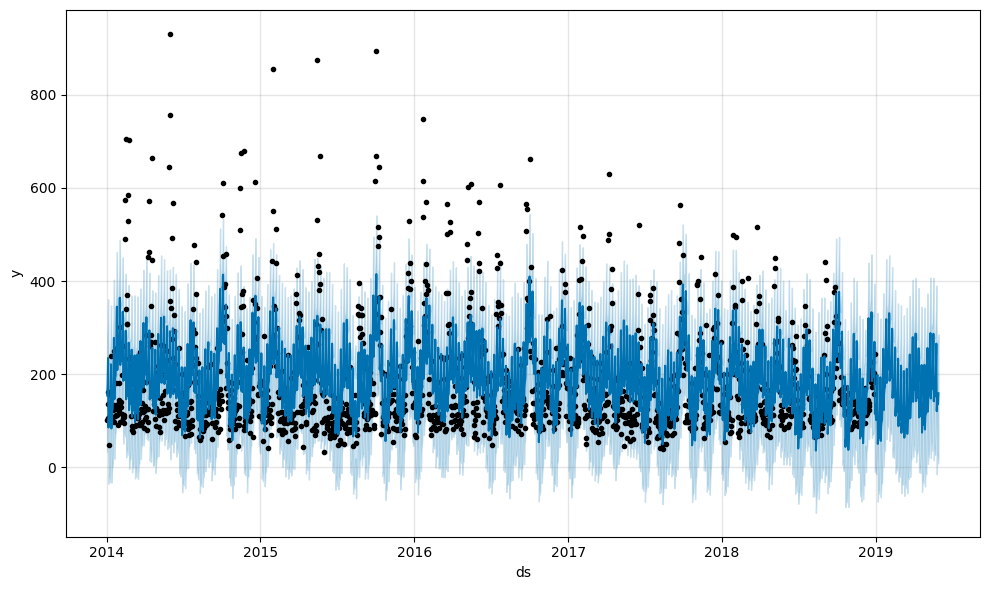

In [133]:
m.plot(forecast)

#**Plot components**

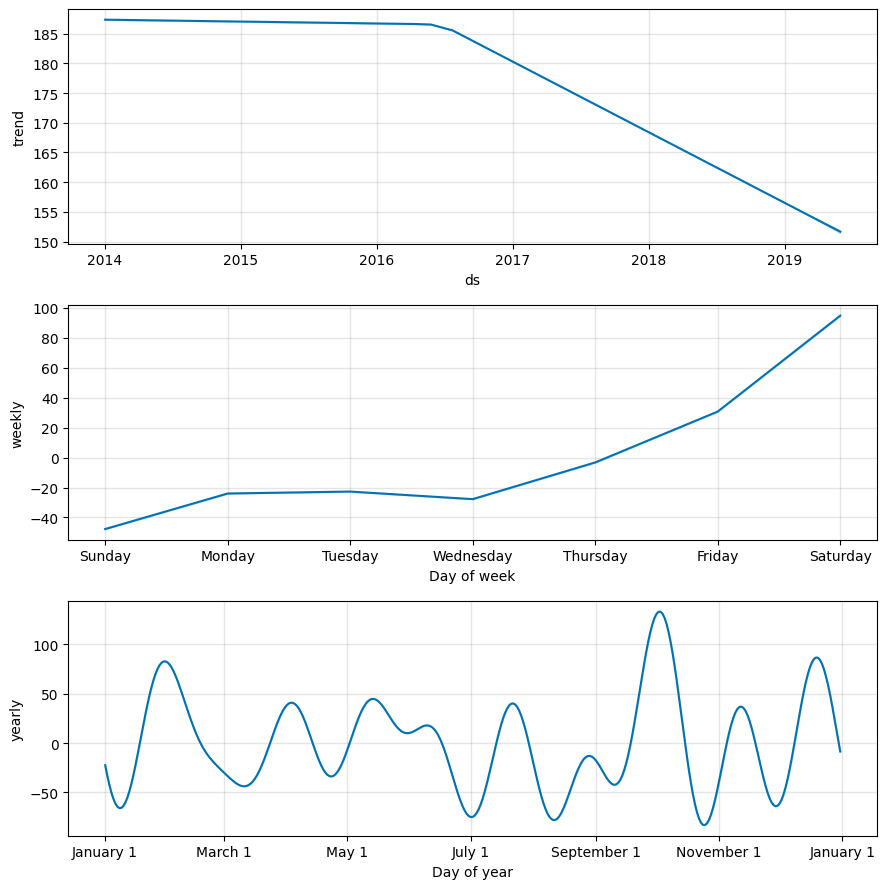

In [134]:
fig2 = m.plot_components(forecast)

#**Use LSTM for predict**

Epoch 1/50
44/44 [==============================] - 2s 6ms/step - loss: 0.0626
Epoch 2/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 3/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0331
Epoch 4/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0318
Epoch 5/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0295
Epoch 6/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0283
Epoch 7/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0278
Epoch 8/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0276
Epoch 9/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0275
Epoch 10/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 11/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 12/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0277
Epoch 13/50
44/44 [==============================

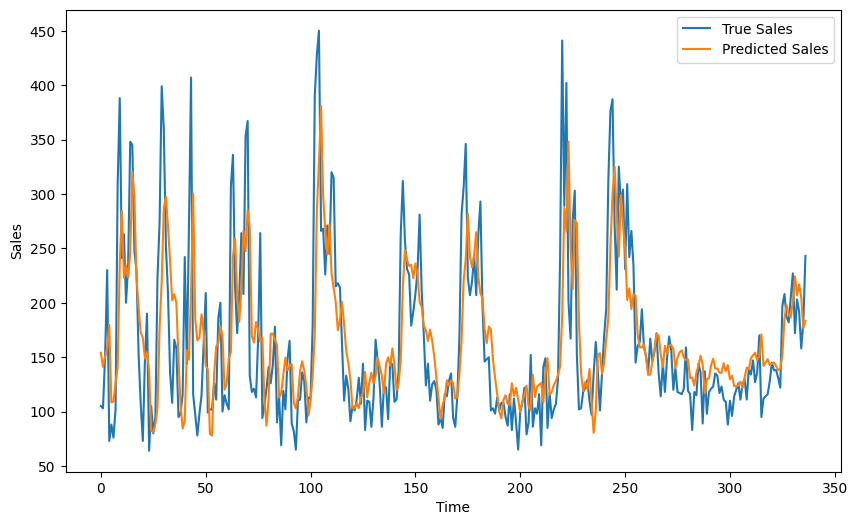

1/1 [==============================] - 0s 28ms/step


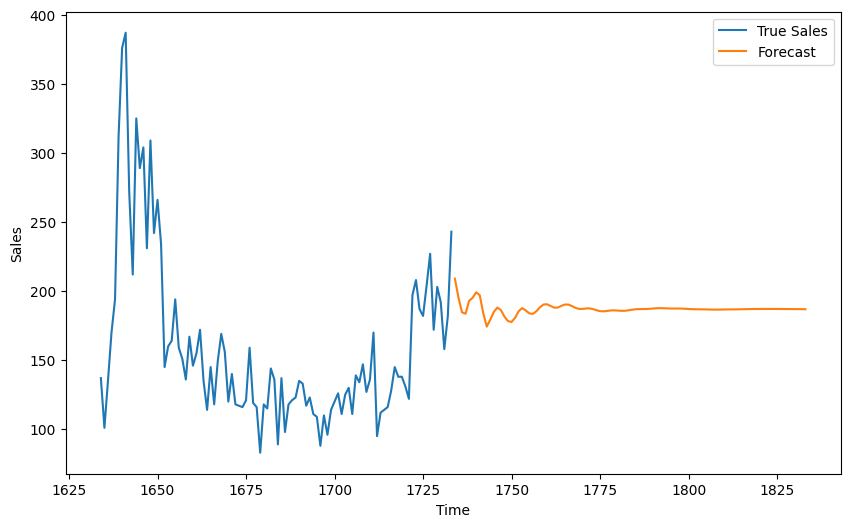

In [150]:
# Prepare sales data
sales = smoothed_data['QTY_B1_TOTAL'].values.reshape(-1, 1)

# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

# Split data into training and test sets
train_size = int(len(scaled_sales) * 0.8)
train_data, test_data = scaled_sales[:train_size], scaled_sales[train_size:]

# Function to create sequence data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

# Model parameters and prepare sequence data
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Create LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on test data
predicted_sales = model.predict(X_test)

# Return data to original scale
predicted_sales = scaler.inverse_transform(predicted_sales)
y_test = scaler.inverse_transform(y_test)

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Sales')
plt.plot(predicted_sales, label='Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Forecast for 180 days ahead
last_sequence = test_data[-seq_length:]  # Last seq_length points of test data
forecast = []
for _ in range(100):
    next_prediction = model.predict(last_sequence.reshape(1, seq_length, 1))
    forecast.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Return forecast to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Visualize forecast for 180 days ahead
plt.figure(figsize=(10, 6))
plt.plot(smoothed_data['QTY_B1_TOTAL'][-100:], label='True Sales')
plt.plot(np.arange(len(smoothed_data), len(smoothed_data) + len(forecast)), forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

